In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import OrthogonalMatchingPursuit
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from matplotlib import style

In [2]:
import matplotlib as mpl
from sklearn.metrics import mean_squared_error, r2_score

avetime = 30
test_fract = 0.2

Coefficients: 
 [[-0.87823045]]
Coefficients: 
 [-0.87823045]
Mov Avg mean squared error: 23707.83
move avg Variance score: -78.40
omp Mov Avg mean squared error: 23707.83
omp move avg Variance score: -78.40
sgd Mov Avg mean squared error: 6574741625282245959876608.00
sgd move avg Variance score: -22018814426245159190528.00


/home/socadmin/anaconda3/envs/newautoencoder/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


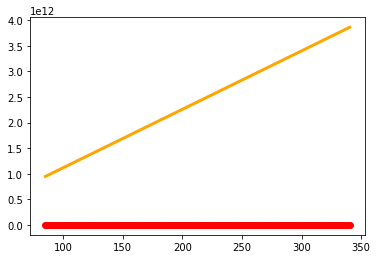

In [4]:
def moving_average(a, n=100):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


df = pd.read_csv('data/AAPL.csv')
close_px = df['Adj Close']

close_px = np.asarray(df['Adj Close'])
close_px = close_px.reshape(-1, 1)
df['Date'] = df['Date'].astype('datetime64[D]')
df['Serial'] = df['Date'] - min(df['Date'])
thedate = np.asarray(df['Serial']) / np.timedelta64(1, 'D')
thedate = thedate.reshape(-1, 1)

mavg = moving_average(np.asarray(close_px), avetime)
mavg = mavg[~np.isnan(mavg)]
mavg = mavg.reshape(-1, 1)

N = mavg.shape[0]
train_data_sz = int(N * (1 - test_fract))


mavg_date = moving_average(np.asarray(thedate), avetime)
mavg_date = mavg_date.reshape(-1, 1)
mavg_date_train = mavg_date[:-train_data_sz]
mavg_date_test = mavg_date[-train_data_sz:]

mavg_train = mavg[:-train_data_sz]
mavg_test = mavg[-train_data_sz:]


# Create linear regression object
regrmavg = linear_model.LinearRegression()
regomp = OrthogonalMatchingPursuit()
regsgd = linear_model.SGDRegressor(max_iter=1000, tol=1e-3)
# Train the model using the training sets

regomp.fit(mavg_date_train, mavg_train)

regrmavg.fit(mavg_date_train, mavg_train)
regsgd.fit(mavg_date_train, mavg_train)

# Make predictions using the testing set
mavg_pred = regrmavg.predict(mavg_date_test)

omp_pred = regomp.predict(mavg_date_test)

sgd_pred = regsgd.predict(mavg_date_test)

# The coefficients
print('Coefficients: \n', regrmavg.coef_)
print('Coefficients: \n', regomp.coef_)

# The mean squared error

print("Mov Avg mean squared error: %.2f"
      % mean_squared_error(mavg_test, mavg_pred))
# Explained variance score: 1 is perfect prediction
print('move avg Variance score: %.2f' % r2_score(mavg_test, mavg_pred))

print("omp Mov Avg mean squared error: %.2f"
      % mean_squared_error(mavg_test, omp_pred))
# Explained variance score: 1 is perfect prediction
print('omp move avg Variance score: %.2f' % r2_score(mavg_test, omp_pred))

print("sgd Mov Avg mean squared error: %.2f"
      % mean_squared_error(mavg_test, sgd_pred))
# Explained variance score: 1 is perfect prediction
print('sgd move avg Variance score: %.2f' % r2_score(mavg_test, sgd_pred))


plt.scatter(mavg_date_test, mavg_test,  color='red')
plt.plot(mavg_date_test, sgd_pred, color='orange', linewidth=3)
plt.show()